# Data Exploration

The `src.crypto_api` module contains useful functions for working with *CoinGecko* API. The available functions are:
 
`create_prices_dataframe(symbols, interval, range_period, sleep_time: int)` - Fetches and combines cryptocurrency prices for specified symbols with a specified time interval and sleep time between requests.
- *Parameters*:
   - `symbols` (list): List of cryptocurrency symbols or IDs (e.g., ["bitcoin", "ethereum"]).
   - `interval` (str): The time interval for the data (e.g., 'daily').
   - `range_period` (int): The number of days for the specified time interval.
   - `sleep_time` (int): The sleep time in seconds between API requests.
- *Returns*:
   - pd.DataFrame: Combined DataFrame with prices for all specified cryptocurrencies.

`get_supported_coins()` - Fetches the list of supported cryptocurrency names or symbols from the CoinGecko API.
-  *Returns*:
   - list: List of supported cryptocurrency names or symbols.

In [1]:
from src import crypto_api

## Data Extraction

First let's examine the supported cryptos by the CoinGecko API:

In [2]:
supported_coins = crypto_api.get_supported_coins()
len(supported_coins)

12300

Now we can save these names on a text file to facilitate its readability:

In [3]:
with open("supported_coins.txt", 'w') as file:
    for coin in supported_coins:
        file.write(f"{coin}\n")

We will analyze five cryptos: bitcoin, ethereum, solana, dogecoin and binancecoin; recovering their daily price from an interval of 365 days until today:

In [4]:
symbols = ["bitcoin", "ethereum", "solana", "dogecoin", "binancecoin"]
interval = "daily"
range_period = 365 * 3 # 3 years
df = crypto_api.create_prices_dataframe(symbols, interval, range_period)
df.head()

Exception: Could not extract binancecoin prices: b'{"status":{"error_code":429,"error_message":"You\'ve exceeded the Rate Limit. Please visit https://www.coingecko.com/en/api/pricing to subscribe to our API plans for higher rate limits."}}'

We remove the last 5 rows as they contain `NaN` values:

In [ ]:
df = df.iloc[:-5]
df.isna().sum()

bitcoin_price        0
ethereum_price       0
solana_price         0
dogecoin_price       0
binancecoin_price    0
dtype: int64

## Data Visualization

The following function `plot_prices()` let us plot the cryptocurrency's prices of our dataframe: 


In [ ]:
import matplotlib.pyplot as plt

def plot_prices(df, **kwargs):
    """Plots cryptocurrency prices over time."""
    df.plot(title="Prices Over Time", figsize=(12, 8), **kwargs)
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.show()

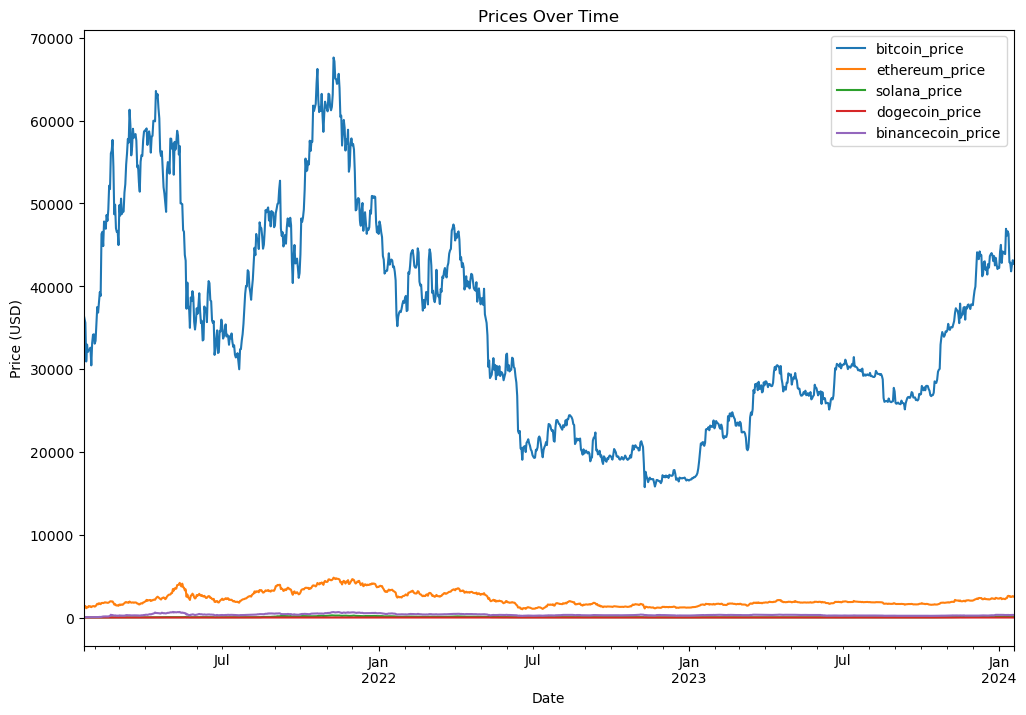

In [ ]:
plot_prices(df)

We can get more insights with the `df.describe()` method:

In [ ]:
df.describe()

,bitcoin_price,ethereum_price,solana_price,dogecoin_price,binancecoin_price
count,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000
mean,34983.087626,2209.426200,57.305291,0.127206,327.462550
std,12624.325813,856.255481,55.107626,0.093978,112.673032
min,15742.444336,995.252569,2.998811,0.007437,38.763739
25%,24700.777978,1626.172826,21.256289,0.067579,247.715554
50%,32409.499767,1881.427405,32.983933,0.082542,305.467458
75%,43818.994204,2697.592527,82.598999,0.160992,385.107993
max,67617.015545,4815.004634,259.239558,0.681842,675.098974


As there is a considerable difference in the price of the cryptocurrency, it is hard to distinguish their behaviour. To solve this, we use *Min-Max Normalization* to normalize the dataframe so each cryptocurrency $c_j$ has prices $p^j = \{p_i \in [0, 1] \mid i = 0, 1, \dots, n\}$ such that $p^j_i$ is the price of $c_j$ at time $i$.

$$
p^{j\prime}_i = \frac{p^j_i - \min(p^j)}{\max(p^j) - \min(p^j)}
$$

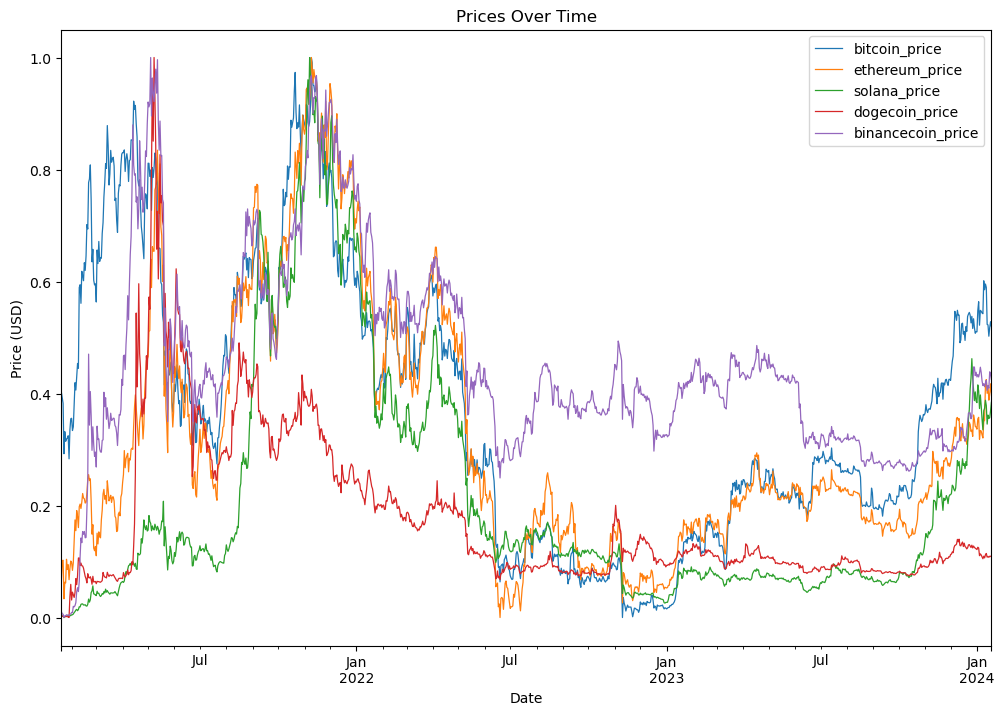

In [ ]:
normalized_df = df.copy()
for crypto in df.columns:
    max_price = df[crypto].max()
    min_price = df[crypto].min()
    normalized_df[crypto] = normalized_df[crypto] - min_price
    normalized_df[crypto] /= max_price - min_price
plot_prices(normalized_df, linewidth=0.9)

As we can observe, there is a common pattern in the cryptocurrencies price. 

In [ ]:
df.corr()

,bitcoin_price,ethereum_price,solana_price,dogecoin_price,binancecoin_price
bitcoin_price,1.000000,0.796590,0.638666,0.550407,0.629453
ethereum_price,0.796590,1.000000,0.886850,0.694438,0.850115
solana_price,0.638666,0.886850,1.000000,0.440008,0.734760
dogecoin_price,0.550407,0.694438,0.440008,1.000000,0.718975
binancecoin_price,0.629453,0.850115,0.734760,0.718975,1.000000


It's worth noting that the normalized dataframe preserves the data correlation:

In [ ]:
normalized_df.corr()

,bitcoin_price,ethereum_price,solana_price,dogecoin_price,binancecoin_price
bitcoin_price,1.000000,0.796590,0.638666,0.550407,0.629453
ethereum_price,0.796590,1.000000,0.886850,0.694438,0.850115
solana_price,0.638666,0.886850,1.000000,0.440008,0.734760
dogecoin_price,0.550407,0.694438,0.440008,1.000000,0.718975
binancecoin_price,0.629453,0.850115,0.734760,0.718975,1.000000


# Cryptocurrency Price Forecasting

## Problem Formulation

We have the historical data of the cryptocurrencies in the form of prices of cryptocurrency accounted on a daily basis [[1]](#references). Let the cryptocurrency prices at the individual timestamps be $\{p_0, p_1, p_2, p_3, \dots, p_n\}$, where $p_i$ denotes price at time stamp $i$. Let the input 
window length be $w$, the input vector be $v$, and the output be $o$, then $v$ and $o$ can be denoted as:

$$
v = [p_{i-w}, p_{i-w+1}, p_{i-w+2}, \dots, p_{i-1}]
$$

$$
o = [p_{i}]
$$

The aim is to predict the $p_{i}$ value using the input vector $v$ containing the past values.

## Data Preparation

We want to format the dataframe for training an LSTM neural network by including past cryptocurrency prices as features.

In [ ]:
def prepare_dataframe_for_lstm(df, symbol, input_window):
    df = df.rename(columns={f"{symbol}_price":"p(i)"})
    df = df[["p(i)"]]
    for i in range(1, input_window + 1):
        df[f"p(i-{i})"] = df["p(i)"].shift(i)
    df.dropna(inplace=True)

    return df

We choose the Bitcoin cryptocurrency and an input window $w=10$. Our input vector $v$ is composed by the columns $p(i-1), p(i-2), \dots, p(i-10)$, and the output value we want to predict is the column $p(i)$.

In [ ]:
btc_prices = prepare_dataframe_for_lstm(df, symbol="bitcoin", input_window=10)
btc_prices.head()

,p(i),p(i-1),p(i-2),p(i-3),p(i-4),p(i-5),p(i-6),p(i-7),p(i-8),p(i-9),p(i-10)
timestamp,,,,,,,,,,,
2021-01-29,33128.347529,30445.525865,32582.109445,32375.320063,32273.517350,32068.087374,32957.908783,30913.695736,35587.489203,36104.863858,36595.464769
2021-01-30,34150.818767,33128.347529,30445.525865,32582.109445,32375.320063,32273.517350,32068.087374,32957.908783,30913.695736,35587.489203,36104.863858
2021-01-31,34199.519810,34150.818767,33128.347529,30445.525865,32582.109445,32375.320063,32273.517350,32068.087374,32957.908783,30913.695736,35587.489203
2021-02-01,33064.786767,34199.519810,34150.818767,33128.347529,30445.525865,32582.109445,32375.320063,32273.517350,32068.087374,32957.908783,30913.695736
2021-02-02,33405.990357,33064.786767,34199.519810,34150.818767,33128.347529,30445.525865,32582.109445,32375.320063,32273.517350,32068.087374,32957.908783


Normalization helps in improving the convergence of the training process and can prevent exploding or vanishing gradients. Therefore, we will use the normalized dataframe and convert it to numpy array to get our training and testing data.

In [ ]:
data = prepare_dataframe_for_lstm(normalized_df, symbol="bitcoin", input_window=10).to_numpy()
data

array([[0.33515271, 0.28343524, 0.32462273, ..., 0.38255824, 0.39253181,
        0.40198926],
       [0.35486316, 0.33515271, 0.28343524, ..., 0.29246028, 0.38255824,
        0.39253181],
       [0.35580199, 0.35486316, 0.33515271, ..., 0.33186712, 0.29246028,
        0.38255824],
       ...,
       [0.51749617, 0.50233646, 0.5225302 , ..., 0.54248737, 0.54388259,
        0.54692029],
       [0.52830427, 0.51749617, 0.50233646, ..., 0.6013301 , 0.54248737,
        0.54388259],
       [0.51993519, 0.52830427, 0.51749617, ..., 0.58532535, 0.6013301 ,
        0.54248737]])

The first column of the array is the label vector $y$, and the other columns are the feature matrix $X$. We also flip $X$ columns so that the first column is $p(i-10)$, the second columns is $p(i-9)$, etc.

In [ ]:
import numpy as np

X = np.flip(data[:, 1:], axis=1)
y = data[:, 0]

X.shape, y.shape

((1085, 10), (1085,))

To work with PyTorch LSTM, it is necessary to introduce an additional dimension to the input data. This ensures that the data conforms to the required shape of `(sequence_length, batch_size, input_size)` [[2]](#references).

In [ ]:
X = X.reshape((*X.shape, 1))
y = y.reshape((*y.shape, 1))

X.shape, y.shape

((1085, 10, 1), (1085, 1))

We split the data into two sets: the training set, comprising the first 95%, and the testing set, consisting of the remaining 5%:

In [ ]:
split_index = int(len(X) * 0.95)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

And convert the arrays to Convert to PyTorch tensors:

In [ ]:
import torch

X_train_tensor = torch.from_numpy(X_train.copy()).float()
X_test_tensor = torch.from_numpy(X_test.copy()).float()
y_train_tensor = torch.from_numpy(y_train.copy()).float()
y_test_tensor = torch.from_numpy(y_test.copy()).float()

Code for processing data samples can get messy and hard to maintain [[3]](#references). PyTorch provides two data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` to handle this issue. Let's create a dataset class to store the train and test data: 

In [ ]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X: torch.Tensor, y: torch.Tensor):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, i: int):
        return self.X[i], self.y[i]
    
    
train_dataset = TimeSeriesDataset(X_train_tensor, y_train_tensor)
test_dataset = TimeSeriesDataset(X_test_tensor, y_test_tensor)

We use PyTorch's `DataLoader` to create efficient data loaders for both training and testing datasets. These loaders enable us to iterate over batches of data, a crucial step during the training and evaluation of our PyTorch model. By specifying a batch size (16 in this case), the data is processed in manageable chunks, enhancing computational efficiency. Additionally, shuffling the training data (`shuffle=True`) helps prevent the model from overfitting to the order of the data, ensuring a more robust training process.

In [ ]:
from torch.utils.data import DataLoader

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

We can confirm that the data loader effectively divides the dataset into batches, each containing precisely 16 samples. To illustrate, we extract the first batch from the training loader:

In [ ]:
first_X_batch, first_y_batch = list(train_loader)[0]
first_X_batch.shape, first_y_batch.shape

(torch.Size([16, 10, 1]), torch.Size([16, 1]))

## LSTM Implementation

The following set of equations defines the computations within an LSTM cell, capturing the dynamics of the input gate, forget gate, cell gate, output gate, hidden state, and cell state:

$$
i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{(t-1)} + b_{hi})\\
f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{(t-1)} + b_{hf})\\
g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{(t-1)} + b_{hg})\\
o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{(t-1)} + b_{ho})\\
c_t = f_t \odot c_{(t-1)} + i_t \odot g_t\\
h_t = o_t \odot \tanh(c_t)
$$


Where:

* **Input Gate ($i_t$):** The input gate controls the flow of information that should be stored in the cell state. It determines which parts of the input and the previous hidden state should be updated.

* **Forget Gate ($f_t$):** The forget gate decides which information from the cell state should be discarded or forgotten. It considers the previous cell state and the current input to determine what information is no longer relevant.

* **Cell Gate ($g_t$):** The cell gate calculates the new candidate values that could be added to the cell state. It uses the input and the previous hidden state to propose new information that could be added to the cell state.

* **Output Gate ($o_t$):** The output gate decides what the next hidden state should be based on the input, the previous hidden state, and the updated cell state. It regulates the information flow from the cell state to the hidden state.

The corresponding PyTorch implementation of an LSTM module is provided below:

In [ ]:
import torch.nn as nn


class LSTM(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int, device: str):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)
        self.device = device
        self.to(device)

    def forward(self, x: torch.Tensor):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

The `LSTM` class has four parameters:

* `input_size` – The number of expected features in the input $x$.
* `hidden_size` – The number of features in the hidden state $h$.
* `num_layers` – Number of recurrent layers. 
* `device` - Device index to select.

> The nn.Linear(hidden_size, 1) layer serves as a fully connected linear layer responsible for mapping the LSTM output of the last time step to a single scalar value. This scalar value represents the final prediction or output of the LSTM network.

We can now set up the device for computation, preferring GPU if available, and then create an LSTM neural network with:

* `input_size=1` - There is only one input: the Bitcoin price vector $x = [p_{i-w}, p_{i-w+1}, p_{i-1}]$.
* `hidden_size=4` - The choice of this parameter depends on the complexity of the patterns we want the network to learn.
* `num_layers=1`: No stacks, only one layer.

> The hidden size is often a hyperparameter that needs to be tuned based on the specific characteristics of your data and the task at hand. A common practice is to start with a small value (e.g., 4 or 8) and gradually increase it if the model performance does not meet expectations.

In [ ]:
device  = "cuda:0" if torch.cuda.is_available() else "cpu"
model = LSTM(input_size=1, hidden_size=4, num_layers=1, device=device)
model

c:\Users\Dylan\miniconda3\envs\ml\Lib\site-packages\torch\cuda\__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ..\c10\cuda\CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

Below are the `train_epoch()` and `validate_epoch()` functions, designed to train and validate the LSTM model for one epoch using a specified dataset.

In [ ]:
from torch.nn import MSELoss
from torch.optim import Adam


def train_epoch(
        model: LSTM, 
        train_loader: DataLoader, 
        loss_function: MSELoss, 
        optimizer: Adam,
        verbose: bool,
    ) -> LSTM:
    model.train(mode=True) # Sets model to training mode
    cumulative_loss = 0

    for batch in train_loader:
        x_batch = batch[0].to(device)
        y_batch = batch[1].to(device)
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        cumulative_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = cumulative_loss / len(train_loader)

    if verbose:
        print(f"-- Training loss: {avg_loss}")

    return avg_loss

def validate_epoch(
        model: LSTM, 
        test_loader: DataLoader, 
        loss_function: MSELoss, 
        verbose: bool,
    ) -> LSTM:
    model.train(False) # Sets model to evaluation mode
    cumulative_loss = 0

    for batch in test_loader:
        x_batch = batch[0].to(device)
        y_batch = batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            cumulative_loss = loss.item()
        
    avg_loss = cumulative_loss/len(test_loader)

    if verbose:
        print(f"-- Validation loss: {avg_loss}")
    
    return avg_loss

The `run_model()` function executes for `num_epochs` epochs, utilizing the provided LSTM model, training data loader, loss function, and optimizer. During each epoch, it calculates the average training loss and validation loss. The results are then organized into a Pandas DataFrame for further analysis. The optional `verbose` parameter allows for detailed progress printing. The function returns the DataFrame with columns for training and validation losses indexed by epoch.

In [ ]:
import pandas as pd

def run_model(
        num_epochs: int,
        model: LSTM, 
        train_loader: DataLoader, 
        test_loader: DataLoader,
        loss_function: MSELoss, 
        optimizer: Adam,
        verbose: bool,
    ) -> LSTM:
    train_loss_list, validation_loss_list = [], []
    for epoch in range(0, num_epochs):
        if verbose:
            print(f"\n\nEpoch {epoch}:")
        train_loss = train_epoch(model, train_loader, loss_function, optimizer, verbose)
        validation_loss = validate_epoch(model, test_loader, loss_function, verbose)
        train_loss_list.append(train_loss)
        validation_loss_list.append(validation_loss)
    
    df = pd.DataFrame(
        {"train_loss":train_loss_list, "validation_loss":validation_loss_list}
        )
    df.index.name = "epoch"
    return df

We will train the LSTM model for 100 epochs using a learning rate of 0.001. During each epoch, the model's parameters will be updated based on the Mean Squared Error (MSE) loss calculated between the predicted and actual values. This iterative process aims to optimize the model's performance on the training data. Subsequently, we will assess the model's generalization to unseen data by validating its performance on the test dataset after each epoch. The learning rate of 0.001 influences the step size in the optimization process, affecting the convergence and stability of the training. Adjustments to the learning rate can significantly impact the training dynamics and final model accuracy.


In [ ]:
learning_rate = 0.001
num_epochs = 100
loss_function = MSELoss()
optimizer = Adam(model.parameters(), lr=learning_rate)
loss_df = run_model(
    num_epochs, model, 
    train_loader, test_loader, 
    loss_function, optimizer, 
    verbose=False)

loss_df.head()

,train_loss,validation_loss
epoch,,
0,0.058473,0.005453
1,0.036447,0.002181
2,0.010302,0.000595
3,0.002229,0.000815
4,0.002099,0.000678


We can plot the losses and see how its decreases as the number of epochs increases:

<Axes: xlabel='epoch', ylabel='MSE Loss'>

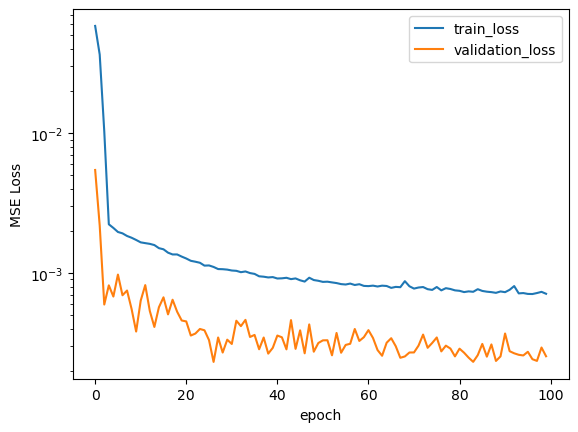

In [ ]:
loss_df.plot(ylabel="MSE Loss", logy=True)

## Model Performance


Now that our LSTM model is trained for BTC price forecasting, let's delve into its performance on both the training and test sets. In this section we will analyze visualizations, such as actual vs. predicted price plots and residual analysis, to comprehensively understand the regression performance of our trained LSTM model.

First, we start by making predictions on the train and test set:

In [ ]:
with torch.no_grad():
    train_predictions = model(X_train_tensor.to(device)).to("cpu").numpy()
    test_predictions = model(X_test_tensor.to(device)).to("cpu").numpy()

> The `torch.no_grad()` context ensures that no gradients are calculated during the prediction phase, as we are not performing any further training.

Once we make our predictions, we can visualize the actual vs. predicted price of the train set:

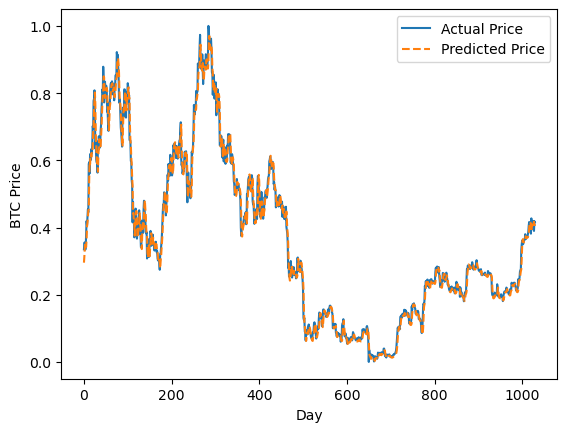

In [ ]:
import matplotlib.pyplot as plt

plt.plot(y_train, label="Actual Price")
plt.plot(train_predictions, label="Predicted Price", linestyle="--")
plt.xlabel("Day")
plt.ylabel("BTC Price")
plt.legend()
plt.show()

Because we normalized the BTC prices to values in the interval $[0, 1]$, the actual BTC prices can be obtained by applying the inverse operation used during the normalization process. Let $p_i$ and $p^{\prime}_i$ represent the actual and normalized prices, respectively, at time instant $i$, and $p$ be the set of prices. The conversion from normalized to actual prices is given by the formula:

$$
p_i = p^{\prime}_i \cdot (\max(p) - \min(p)) + \min(p)
$$

This formula scales the normalized prices back to the original scale, allowing us to obtain the real BTC prices. To apply this transformation to the normalized Bitcoin prices from the training and testing arrays, we calculate the maximum and minimum values from the original dataset. Then, we use these values in the following calculations:

In [ ]:
max_price = df["bitcoin_price"].max()
min_price = df["bitcoin_price"].min()

real_y_train = y_train * (max_price - min_price) - min_price
real_train_predictions = train_predictions * (max_price - min_price) - min_price
real_y_test = y_test * (max_price - min_price) - min_price
real_test_predictions = test_predictions * (max_price - min_price) - min_price

To gain insights into the performance of our Bitcoin price prediction model, we visualize the actual and predicted prices from the test dataset. The x-axis represents the days, starting from the day following the last day of the training set.

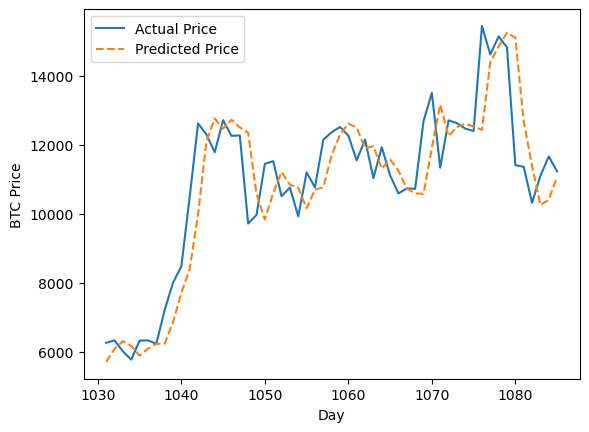

In [ ]:
# Determine the x-axis range for the test set
# Start from the day following the last day of the training set
len_train, len_test = len(y_train), len(y_test)
x_range = np.arange(len_train + 1, len_train + len_test + 1)

# Plot actual and predicted prices
plt.plot(x_range, real_y_test, label="Actual Price")
plt.plot(x_range, real_test_predictions, label="Predicted Price", linestyle="--")
plt.xlabel("Day")
plt.ylabel("BTC Price")
plt.legend()
plt.show()

# References

[1] Mohil Maheshkumar Patel, Sudeep Tanwar, Rajesh Gupta, Neeraj Kumar (2020). *A Deep Learning-based Cryptocurrency Price Prediction Scheme for Financial Institutions*.

[2] PyTorch Documentation. *torch.nn.LSTM*. PyTorch, version 2.1. Available: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

[3] PyTorch Tutorials. *Datasets & DataLoaders*. PyTorch, version 2.2.0+cu121. Available: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

[4] Yong Yu, Xiaosheng Si, Changhua Hu, Jianxun Zhang. *A Review of Recurrent Neural Networks: LSTM Cells and Network Architectures*.